In [1]:
# import modules

import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from pathlib import Path
from tqdm import tqdm
from time import perf_counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
from IPython.display import Markdown, display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
# Load data
data_dir = Path('/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image')
filepaths = list(data_dir.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
    Creates a DataFrame from the image data path and label data.
    """
    valid_filepaths = [f for f in filepath if f.parent.name]  # Filters paths with a parent directory

    labels = [f.parent.name for f in valid_filepaths]  # Extracts parent directory names from Path objects

    filepath = pd.Series([str(f) for f in valid_filepaths], name='Filepath')
    labels = pd.Series(labels, name='Label')

    # Concatenate the path and label
    df = pd.concat([filepath, labels], axis=1)

    # Reset the iniex
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,\Users\belli\Desktop\youn\marburg\XAI\Practica...,nature
1,\Users\belli\Desktop\youn\marburg\XAI\Practica...,urban
2,\Users\belli\Desktop\youn\marburg\XAI\Practica...,urban
3,\Users\belli\Desktop\youn\marburg\XAI\Practica...,urban
4,\Users\belli\Desktop\youn\marburg\XAI\Practica...,nature


In [3]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 5000

Number of different labels: 2

Labels: ['nature' 'urban']


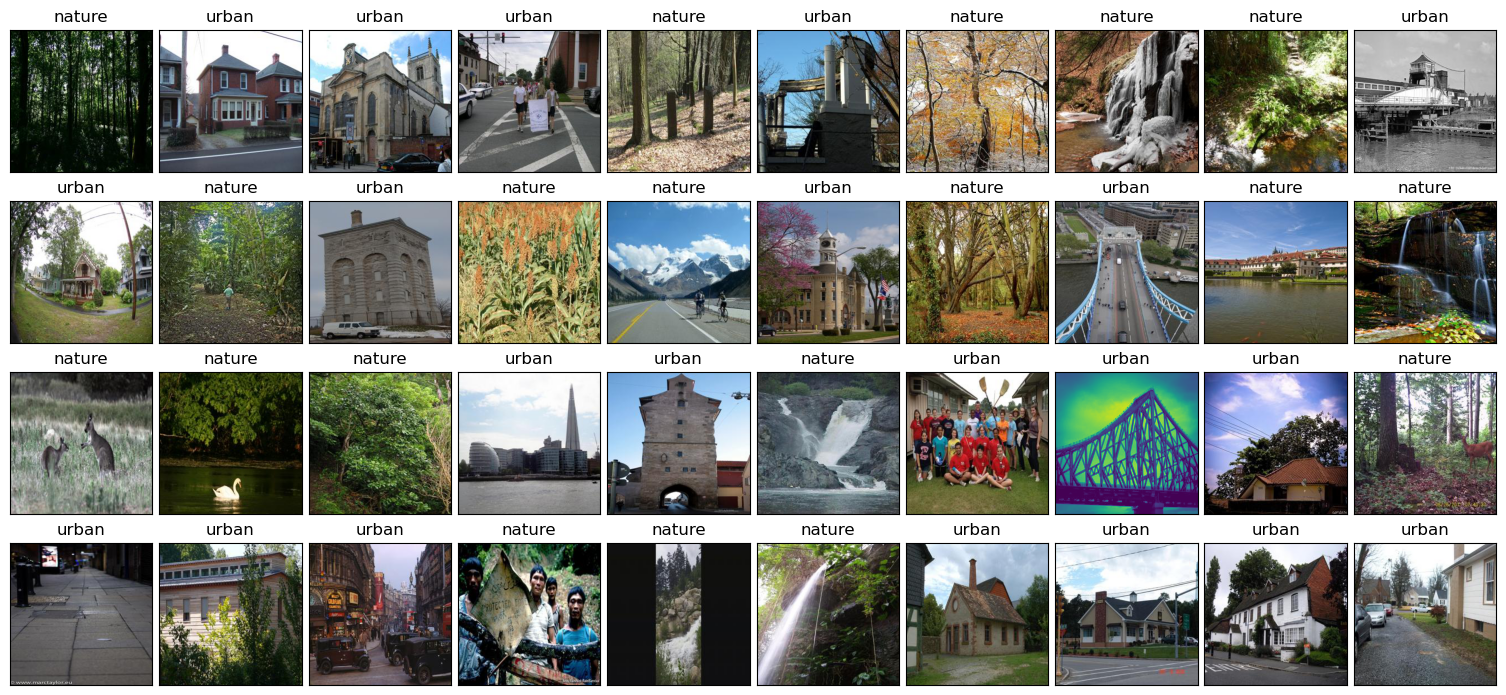

In [4]:
# Display Image Data

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [5]:
# Image Preprocessing

# Training/test split
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((4500, 2), (500, 2))

In [6]:
# Baseline Model Setup

# Data Preprocessing
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

# Baseline CNN Model
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=2, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


C:\Users\belli\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,318,946 (20.29 MB)

 Trainable params: 5,318,946 (20.29 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Model performance evaluation
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

C:\Users\belli\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.5555 - loss: 1.0944 - val_accuracy: 0.7370 - val_loss: 0.5175
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.7425 - loss: 0.5210 - val_accuracy: 0.7720 - val_loss: 0.4751
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.7962 - loss: 0.4267 - val_accuracy: 0.7910 - val_loss: 0.4413
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 0.8319 - loss: 0.3729 - val_accuracy: 0.7900 - val_loss: 0.4554
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.8989 - loss: 0.2370 - val_accuracy: 0.7490 - val_loss: 0.5535
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9443 - loss: 0.1648 - val_accuracy: 0.7710 - val_loss: 0.5981
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.9824 - loss: 0.0691 - val_accuracy: 0.7740 - val_loss: 0.6918
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.9889 - loss: 0

In [8]:
# Create a data generator for image augmentation

def create_gen():
    # Create generators and load images with augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',  # Column name for file paths
        y_col='Label',  # Column name for class labels
        target_size=(224, 224),  # Image size
        color_mode='rgb',  # Image color mode
        class_mode='categorical',  # Class mode for output
        batch_size=32,
        shuffle=True,  # Shuffle the data
        seed=0,
        subset='training',  # Use the training subset
        rotation_range=30,  # Randomly rotate images by up to 30 degrees
        zoom_range=0.15,  # Randomly zoom images by up to 15%
        width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
        height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
        shear_range=0.15,  # Shear intensity (magnitude of shearing)
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode="nearest"  # Fill in newly created pixels with the nearest pixel (constant, nearest, reflect, wrap)
    )
    
    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
# Transfer Learning

models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False  # Freeze pre-trained layers for efficiency
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    # 2 output units as we have 2 classes
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train Models
for name, model in models.items():
    
    # Get transfer learning model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Train the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # Record training time and validation accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 4050 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.




C:\Users\belli\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


DenseNet121          trained in 131.22 sec
MobileNetV2          trained in 39.82 sec
DenseNet201          trained in 207.95 sec
EfficientNetB0       trained in 73.04 sec


In [ ]:
# Model Performance Evaluation

# Predict on the test data
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Model performance valuation

train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)

# Accuracy
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Loss
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# Predict the label of the test_images
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

----------------------------------------------------------------------------------

In [ ]:
# Grad-CAM (1)

def grad_cam(model, img_array, layer_name, class_idx=None):
    """
    Calculates Grad-CAM for a given image and model.

    Args:
        model: The pre-trained model.
        img_array: The input image array (4D tensor, (1, height, width, channels)).
        layer_name: The name of the layer for which to compute Grad-CAM.
        class_idx: The class index of interest (if None, the class with the highest prediction is used).

    Returns:
        heatmap: The Grad-CAM heatmap.
    """
    # Get model outputs and intermediate layer outputs
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Use tf.GradientTape to calculate gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Calculate gradients of the loss with respect to the outputs of the convolution layer
    grads = tape.gradient(loss, conv_outputs)

    # Calculate importance weights: Global Average Pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by its importance weight
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_grad_cam(image_path, model, layer_name, class_idx=None):
    """
    Visualizes the Grad-CAM result
    """
    # Preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Calculate Grad-CAM
    heatmap = grad_cam(model, img_array, layer_name, class_idx)

    # Visualize the heatmap
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # Overlay on the original images
    plt.axis('off')
    plt.show()

# Example usage
display_grad_cam('/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image/nature/field-wild-00000329.jpg', model, 'conv5_block16_concat')

In [ ]:
# Grad-CAM (2)
# Reducing the pixel size

def grad_cam(model, img_array, layer_name, class_idx=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Grad-CAM Visualization Function
def display_grad_cam(image_path, model, layer_name, class_idx=None):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    heatmap = grad_cam(model, img_array, layer_name, class_idx)

    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (224, 224)).numpy()
    heatmap = np.squeeze(heatmap)
    heatmap = np.clip(heatmap, 0, 1)

    original_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    original_img = tf.keras.preprocessing.image.img_to_array(original_img).astype(np.uint8)

    colormap = plt.cm.jet(heatmap)[:, :, :3]
    colormap = np.uint8(255 * colormap)

    overlayed_img = 0.6 * original_img + 0.4 * colormap
    overlayed_img = np.uint8(overlayed_img)

    return overlayed_img

# Randomly Selecting Images for Grad-CAM and Visualization
def random_grad_cam(folder_path, model, layer_name, num_images=10):
    # Exploring the 'nature' and 'urban' Folders
    nature_path = os.path.join(folder_path, "nature")
    urban_path = os.path.join(folder_path, "urban")
    
    # Getting All Image Files from Both Folders
    nature_images = [os.path.join(nature_path, img) for img in os.listdir(nature_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    urban_images = [os.path.join(urban_path, img) for img in os.listdir(urban_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    
    # Combining Images from Both Folders and Random Sampling
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    
    # Running Grad-CAM and Visualization
    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(selected_images):
        overlayed_img = display_grad_cam(image_path, model, layer_name)
        plt.subplot(2, 5, i + 1)  # 2행 5열의 서브플롯
        plt.imshow(overlayed_img)
        plt.title(os.path.basename(image_path))  # 파일 이름 표시
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pre-trained Model and Layer Name
model = tf.keras.applications.MobileNetV2(weights="imagenet")
layer_name = "Conv_1_bn"

# Execution: 'image' Folder Path
folder_path = "/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image"
random_grad_cam(folder_path, model, layer_name, num_images=10)


In [ ]:
# Grad-CAM (3)
# Show what the image was classified as
def grad_cam(model, img_array, layer_name, class_idx=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), predictions.numpy()

# Grad-CAM visualization function
def display_grad_cam(image_path, model, layer_name):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    heatmap, predictions = grad_cam(model, img_array, layer_name)

    # Decode prediction results (ImageNet class)
    decoded_preds = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=1)
    pred_label = decoded_preds[0][0][1]  # 클래스 이름
    pred_confidence = decoded_preds[0][0][2]  # 확률

    # Resize heatmap
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (224, 224)).numpy()
    heatmap = np.squeeze(heatmap)
    heatmap = np.clip(heatmap, 0, 1)

    # Load original image
    original_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    original_img = tf.keras.preprocessing.image.img_to_array(original_img).astype(np.uint8)

    # Apply colormap
    colormap = plt.cm.jet(heatmap)[:, :, :3]
    colormap = np.uint8(255 * colormap)

    # Overlay original image and colormap
    overlayed_img = 0.6 * original_img + 0.4 * colormap
    overlayed_img = np.uint8(overlayed_img)

    return overlayed_img, pred_label, pred_confidence

# Randomly select images and run Grad-CAM for visualization
def random_grad_cam(folder_path, model, layer_name, num_images=10):
    # Search for nature and urban folders
    nature_path = os.path.join(folder_path, "nature")
    urban_path = os.path.join(folder_path, "urban")
    
    # Get all image files from both folders
    nature_images = [os.path.join(nature_path, img) for img in os.listdir(nature_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    urban_images = [os.path.join(urban_path, img) for img in os.listdir(urban_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    
    # Combine images from both folders and sample randomly
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    
    # Run Grad-CAM and visualize
    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(selected_images):
        overlayed_img, pred_label, pred_confidence = display_grad_cam(image_path, model, layer_name)
        plt.subplot(2, 5, i + 1)  # 2행 5열의 서브플롯
        plt.imshow(overlayed_img)
        plt.title(f"{os.path.basename(image_path)}\n{pred_label} ({pred_confidence:.2f})")  # 파일 이름과 예측 결과
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pre-trained model and layer name
model = tf.keras.applications.MobileNetV2(weights="imagenet")
layer_name = "Conv_1_bn"

# Execution: 'image' folder path
folder_path = "/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image"
random_grad_cam(folder_path, model, layer_name, num_images=10)


In [ ]:
# Grad-CAM (4)
# Performs Grad-CAM for urban/nature binary classification
def grad_cam(model, img_array, layer_name, class_idx=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), predictions.numpy()

# Grad-CAM visualization function
def display_grad_cam(image_path, model, layer_name, urban_classes, nature_classes):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    heatmap, predictions = grad_cam(model, img_array, layer_name)

    # Decoding predictions (ImageNet classes)
    decoded_preds = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=5)
    pred_label = decoded_preds[0][0][1]  # 클래스 이름
    pred_confidence = decoded_preds[0][0][2]  # 확률

    # Urban/nature classification
    urban_score = sum(predictions[0, urban_classes])
    nature_score = sum(predictions[0, nature_classes])
    final_label = "urban" if urban_score > nature_score else "nature"
    final_confidence = max(urban_score, nature_score)

    # Resize heatmap
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (224, 224)).numpy()
    heatmap = np.squeeze(heatmap)
    heatmap = np.clip(heatmap, 0, 1)

    # Load original image
    original_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    original_img = tf.keras.preprocessing.image.img_to_array(original_img).astype(np.uint8)

    # Apply colormap
    colormap = plt.cm.jet(heatmap)[:, :, :3]
    colormap = np.uint8(255 * colormap)

    # Overlay original image with colormap
    overlayed_img = 0.6 * original_img + 0.4 * colormap
    overlayed_img = np.uint8(overlayed_img)

    return overlayed_img, final_label, final_confidence

# Randomly select images and perform Grad-CAM visualization
def random_grad_cam(folder_path, model, layer_name, urban_classes, nature_classes, num_images=10):
    # Explore nature/urban folders
    nature_path = os.path.join(folder_path, "nature")
    urban_path = os.path.join(folder_path, "urban")
    
    # Get all image files from both folders
    nature_images = [os.path.join(nature_path, img) for img in os.listdir(nature_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    urban_images = [os.path.join(urban_path, img) for img in os.listdir(urban_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    
    # Combine images from both folders and perform random sampling
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    
    # Perform Grad-CAM and visualization
    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(selected_images):
        overlayed_img, final_label, final_confidence = display_grad_cam(
            image_path, model, layer_name, urban_classes, nature_classes)
        plt.subplot(2, 5, i + 1)  # 2행 5열의 서브플롯
        plt.imshow(overlayed_img)
        plt.title(f"{final_label} ({final_confidence:.2f})")  # urban/nature 및 확률
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pre-trained model and layer name
model = tf.keras.applications.MobileNetV2(weights="imagenet")
layer_name = "Conv_1_bn"

# Urban/nature class mapping (ImageNet class indices)
urban_classes = [555, 834, 835, 873]  # e.g., dam, building
nature_classes = [970, 972, 976, 978]  # e.g., valley, forest

# Execution: 'image' folder path
folder_path = "/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image"
random_grad_cam(folder_path, model, layer_name, urban_classes, nature_classes, num_images=10)


In [ ]:
# lIME

def explain_with_lime(model, img_path):
    """
    Generates and visualizes an explanation for an image using LIME.

    Args:
        model: A pre-trained Keras model (e.g., VGG16).
        img_path: The path to the image.
    """

    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Scale to [0, 1]
    img_array = preprocess_input(img_array)  # Preprocess for VGG16
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

    # Make a prediction with the model
    preds = model.predict(img_array)
    decoded_preds = decode_predictions(preds, top=2)[0]  # Decode top 2 predictions
    pred_label = decoded_preds[0][1]  # Class name with the highest probability
    pred_confidence = decoded_preds[0][2]  # Probability of that class

    # Initialize LIME image explainer
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_array[0],
        model.predict,
        top_labels=2,
        hide_color=0,  # Set the background to black
        num_samples=1000
    )

    # Get the explanation results
    label = explanation.top_labels[0]  # Select the top label
    temp, mask = explanation.get_image_and_mask(
        label=label,
        positive_only=False,  # Show both positive and negative regions
        hide_rest=False  # Don't hide the background
    )

    # Combine the original image with the mask
    original_img = img_to_array(load_img(img_path, target_size=(224, 224))) / 255.0  # Original image in [0, 1]
    mask = mask.astype(np.float32)  # Convert mask to float32
    mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension (H, W) -> (H, W, 1)

    # Combine the mask and original image (show original image only in highlighted areas)
    highlighted_img = mask * original_img + (1 - mask) * 0.5  # Keep background at 50% brightness

    # Visualization
    plt.figure(figsize=(5, 5))  # Adjust output image size (5x5 inches)
    plt.imshow(highlighted_img, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'LIME Explanation\nPredicted: {pred_label} ({pred_confidence:.2f})')
    plt.show()

def random_lime(folder_path, model, num_images=5):
    """
    Randomly selects images from the given folder and runs LIME on them.

    Args:
        folder_path: The path to the image folder.
        model: A pre-trained Keras model (e.g., VGG16).
        num_images: Number of images to process.
    """
    nature_folder = os.path.join(folder_path, 'nature')
    urban_folder = os.path.join(folder_path, 'urban')

    # Collect image paths from nature and urban folders
    nature_images = [os.path.join(nature_folder, img) for img in os.listdir(nature_folder) if img.endswith(('.jpg', '.png'))]
    urban_images = [os.path.join(urban_folder, img) for img in os.listdir(urban_folder) if img.endswith(('.jpg', '.png'))]

    # Combine images from both folders and sample randomly
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))

    # Run LIME and visualize results
    for i, img_path in enumerate(selected_images):
        print(f"Processing image {i+1}: {img_path}")
        explain_with_lime(model, img_path)

# 1. Load a pre-trained model
model = VGG16(weights="imagenet")

# 2. Run: Specify the 'image' folder path
folder_path = '/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image'
random_lime(folder_path, model, num_images=5)